# Project 1
Group member:

Yat Chit Law

Karthikeyan Jeyabalasuntharam

## Topic: GANs model for photo-to-monet translation
Dataset: https://www.kaggle.com/competitions/gan-getting-started

**Importing Libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pathlib
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, ReLU, ZeroPadding2D, GroupNormalization, Concatenate, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

**Loading the Dataset**

In [32]:
dir_PATH = pathlib.Path('C:/Users/yatch/Desktop/Advanced Applied Mathematical concept of Machine learning/Project 1/gan-getting-started')

In [33]:
monet_files= tf.io.gfile.glob(str(dir_PATH) + '/monet_tfrec/*.tfrec')
photo_files= tf.io.gfile.glob(str(dir_PATH) + '/photo_tfrec/*.tfrec')

In [34]:
print('No. of Monet TFRecord files: ',len(monet_files))
print('No. of Photo TFRecord files: ',len(photo_files))

No. of Monet TFRecord files:  5
No. of Photo TFRecord files:  20


Dataset include:

Monet image: 300

Photo image: 7038

All the images for the dataset are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [35]:
IMAGE_SIZE= [256,256]                                            

def decode_img(image):                                           # function for decoding the image present in jpeg format
    image= tf.image.decode_jpeg(image,channels= 3)               
    image= (tf.cast(image, tf.float32)/255)*2 -1                 
    image= tf.reshape(image, shape= [*IMAGE_SIZE,3])             
    return image

def read_tfrec(example):                                         # function for extracting image from TFRecord format
    tfrec_format= {
        'image_name': tf.io.FixedLenFeature([], tf.string),      
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    example= tf.io.parse_single_example(example, tfrec_format)
    image= decode_img(example['image'])
    return image

In [36]:
def load_data(files):
    data= tf.data.TFRecordDataset(files)
    data= data.map(read_tfrec)
    return data

In [37]:
monet_data= load_data(monet_files).batch(1)                      
photo_data= load_data(photo_files).batch(1)

In [38]:
monet_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

In [39]:
ex_monet= next(iter(monet_data))
ex_photo= next(iter(photo_data))

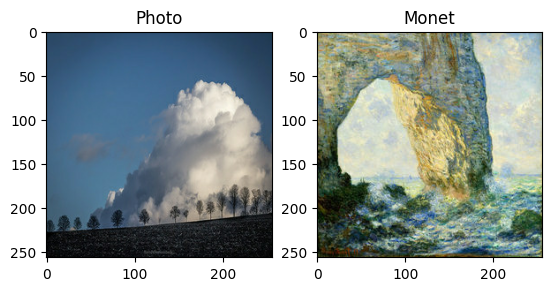

In [40]:
plt.subplot(1,2,1)                                       
plt.title('Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Monet')
plt.imshow(ex_monet[0]*0.5 +0.5)                   

**Building the Generator (UNET Architecture)**

In [41]:
def downsample(filters, size, instance_norm= True):                                   # for extracting important features
    initializer= tf.random_normal_initializer(0,0.02)                                 # mean=0 and standard deviation=0.02 for initializing kernel weights
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()                                          
    model.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer= initializer, use_bias= False))
    
    if instance_norm:
         model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))     # groups= -1 to make it work like Instance Normalization
   
    model.add(LeakyReLU())
    
    return model

In [42]:
def upsample(filters, size, dropout= False):                                         # for locating features accurately using skip connections 
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    
    model= keras.Sequential()
    model.add(Conv2DTranspose(filters, size, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False))
    model.add(GroupNormalization(groups= -1, gamma_initializer= gamma_init))
    
    if dropout:
        model.add(Dropout(0.5))
    
    model.add(ReLU())
    
    return model

In [43]:
def generator():
    down_stack= [
        downsample(64,4,False),                 
        downsample(128,4),                     
        downsample(256,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
        downsample(512,4),                      
    ]
    
    up_stack= [
        upsample(512,4,True),                       
        upsample(512,4,True),                
        upsample(512,4,True),                
        upsample(512,4),                       
        upsample(256,4),                      
        upsample(128,4),                        
        upsample(64,4)                          
    ]
    
    initializer= tf.random_normal_initializer(0,0.02)
    last_layer= Conv2DTranspose(3, 4, strides= 2, padding= 'same', kernel_initializer= initializer, activation= 'tanh')     # 3 output channels required
    
    i= Input(shape= [256,256,3])                # input layer
    x= i
    skips= []
    for down in down_stack:                     # downsampling
        x= down (x) 
        skips.append(x)                         # appending skip connections to the 'skips' list
        
    skips= reversed(skips[:-1])                 # last skip connection is not used because of alignment with upsampling path
    
    for up, skip in zip(up_stack,skips):        # upsampling and concatenating output with skip connection
        x= up (x)
        x= Concatenate() ([x,skip])
        
    x= last_layer(x)                            # last layer (Conv2DTranspose) for generating the final output 
    
    model= Model(i,x)
    
    return model

**Building the Discriminator**

In [44]:
def discriminator():
    i= Input(shape= [256,256,3])
    x= downsample(64,4) (i)                                 
    x= downsample(128,4) (x)                              
    x= downsample(256,4) (x)                              
    
    x= ZeroPadding2D() (x)                                 
    
    initializer= tf.random_normal_initializer(0,0.02)
    gamma_init= keras.initializers.RandomNormal(mean= 0, stddev= 0.02)
    x= Conv2D(512, 4, strides= 2, padding= 'same', kernel_initializer= initializer, use_bias= False) (x)      
    x= GroupNormalization(groups= -1, gamma_initializer= gamma_init) (x)
    x= LeakyReLU() (x)
    
    x= ZeroPadding2D() (x)                                 
    
    x= Conv2D(1, 4, padding= 'same', kernel_initializer= initializer) (x)       
    model= Model(i,x)                                                                      
    
    return model

**Initializing the generator & discriminator objects**

In [45]:
# with strategy.scope():
monet_generator= generator()                     # photo to monet-esque
monet_discriminator= discriminator()             # to differentiate between generated monet-esque images and real monet-esque images
photo_generator= generator()                     # monet-esque to photo
photo_discriminator= discriminator()             # to differentiate between generated 'normal' images and real 'normal' images

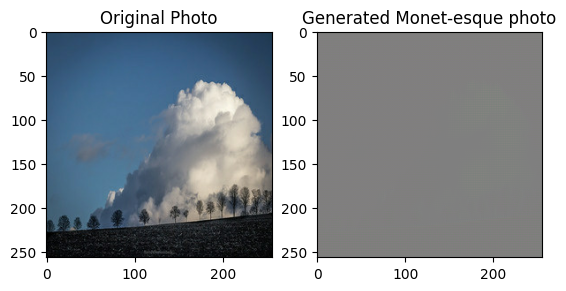

In [46]:
photo_to_monet= monet_generator(ex_photo)                

plt.subplot(1,2,1)                                      
plt.title('Original Photo')
plt.imshow(ex_photo[0]*0.5 +0.5)                         # rescaling the image to [0,1] for displaying

plt.subplot(1,2,2)
plt.title('Generated Monet-esque photo')
plt.imshow(photo_to_monet[0]*0.5 +0.5)                   

**Building the CycleGAN**

In [47]:
class CycleGAN(keras.Model):                       # CycleGAN class inheriting from keras.Model class so that it can use its methods to train, compile etc.
    def __init__(                                  # arguments to be passed in a CycleGAN class object   
        self,
        monet_gen,
        monet_disc,
        photo_gen,
        photo_disc,
        lambda_cycle= 10                          
    ):
        super(CycleGAN,self).__init__()            # calls the constructor of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen= monet_gen                      # assigning argument values to attributes of a CycleGAN class object/instance
        self.m_disc= monet_disc
        self.p_gen= photo_gen
        self.p_disc= photo_disc
        self.lambda_cycle= lambda_cycle
        
    def compile(                                   
        self,
        m_gen_optimizer,
        m_disc_optimizer,
        p_gen_optimizer,
        p_disc_optimizer,
        gen_loss_function,
        disc_loss_function,
        cycle_loss_function,
        identity_loss_function
    ):
        super(CycleGAN,self).compile()             # calls the 'compile' fn of the parent class (keras.Model), initializing the base properties and methods
        self.m_gen_optimizer = m_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_function = gen_loss_function
        self.disc_loss_function = disc_loss_function
        self.cycle_loss_function = cycle_loss_function
        self.identity_loss_function = identity_loss_function
        
    def train_step(self,batch_data):                                # automatically invoked when fit() method is called 
        real_monet, real_photo= batch_data
        
        with tf.GradientTape(persistent= True) as tape:             # to keep a track of operations (persistent= True bcz of multiple calls to Gradient())
            
            fake_monet= self.m_gen(real_photo, training= True)      # photo to monet and then cycled back to photo
            cycled_photo= self.p_gen(fake_monet, training= True)
            
            fake_photo= self.p_gen(real_monet, training= True)      # monet to photo and then cycled back to monet
            cycled_monet= self.m_gen(fake_photo, training= True)
            
            same_photo= self.p_gen(real_photo, training= True)      # generating itself (useful in calculating identity loss)
            same_monet= self.m_gen(real_monet, training= True)      
            
            disc_real_photo= self.p_disc(real_photo, training= True)   # discriminator used to check by inputing real images
            disc_real_monet= self.m_disc(real_monet, training= True)   
            
            disc_fake_photo= self.p_disc(fake_photo, training= True)   # discriminator used to check by inputing fake images
            disc_fake_monet= self.m_disc(fake_monet, training= True)
            
            gen_monet_loss= self.gen_loss_function(disc_fake_monet)    # generator loss
            gen_photo_loss= self.gen_loss_function(disc_fake_photo)
            
            total_cycle_loss = (self.cycle_loss_function(real_monet, cycled_monet, self.lambda_cycle) +     # total cycle consistency loss
            self.cycle_loss_function(real_photo, cycled_photo, self.lambda_cycle))
            
            total_gen_monet_loss= (gen_monet_loss + total_cycle_loss   +                                    # total generator monet loss
            self.identity_loss_function(real_monet, same_monet, self.lambda_cycle) )  
            
            total_gen_photo_loss= (gen_photo_loss + total_cycle_loss   +                                    # total generator photo loss
            self.identity_loss_function(real_photo, same_photo, self.lambda_cycle) )
            
            disc_monet_loss= self.disc_loss_function(disc_real_monet, disc_fake_monet)                      # discriminator monet loss 
            disc_photo_loss= self.disc_loss_function(disc_real_photo, disc_fake_photo)                      # discriminator photo loss
            
            
        gen_monet_gradients= tape.gradient(total_gen_monet_loss, self.m_gen.trainable_variables)            # calculate gradients for generators
        gen_photo_gradients= tape.gradient(total_gen_photo_loss, self.p_gen.trainable_variables)            # diff loss fn wrt trainable variables of model
        
        disc_monet_gradients= tape.gradient(disc_monet_loss, self.m_disc.trainable_variables)               # calculate gradients for discriminators
        disc_photo_gradients= tape.gradient(disc_photo_loss, self.p_disc.trainable_variables)
        
        self.m_gen_optimizer.apply_gradients(zip(gen_monet_gradients, self.m_gen.trainable_variables))      # apply the gradients to optimizer
        self.p_gen_optimizer.apply_gradients(zip(gen_photo_gradients, self.p_gen.trainable_variables))      # basically performing gradient descent
        self.m_disc_optimizer.apply_gradients(zip(disc_monet_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(disc_photo_gradients, self.p_disc.trainable_variables))
        
        return {
            'gen_monet_loss': total_gen_monet_loss,
            'gen_photo_loss': total_gen_photo_loss,
            'disc_monet_loss': disc_monet_loss,
            'disc_photo_loss': disc_photo_loss
        }

**Loss Functions**

In [48]:
# with strategy.scope():
def gen_loss_fn(generated):            
    return BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [49]:
# with strategy.scope():
def disc_loss_fn(real, generated):
    loss_real= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    loss_fake= BinaryCrossentropy(from_logits= True, reduction= tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)
        
    total_loss= (loss_real + loss_fake)/2
        
    return total_loss

In [50]:
# with strategy.scope():
def cycle_loss_fn(real, cycled, lambda_cycle):
    loss= tf.reduce_mean(tf.abs(real - cycled))
        
    return lambda_cycle*loss                       

In [51]:
# with strategy.scope():
def identity_loss_fn(real, same, Lambda):          
    loss= tf.reduce_mean(tf.abs(real - same))
        
    return Lambda*loss*0.5                         

**Optimizers**

In [52]:
# with strategy.scope():
m_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
m_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

p_gen_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)
p_disc_opt= Adam(learning_rate= 2e-4, beta_1= 0.5)

**Compiling and Training/Fitting**

In [53]:
# with strategy.scope():
cyclegan_model= CycleGAN(monet_generator, monet_discriminator, photo_generator, photo_discriminator, 10)
cyclegan_model.compile(m_gen_opt, m_disc_opt, p_gen_opt, p_disc_opt, gen_loss_fn, disc_loss_fn, 
                        cycle_loss_fn, identity_loss_fn)

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.losses = {'disc_monet_loss': [], 'disc_photo_loss': [], 'gen_monet_loss': [], 'gen_photo_loss': []}
        
    def on_epoch_end(self, epoch, logs=None):
        # Record the specific losses
        self.losses['disc_monet_loss'].append(logs.get('disc_monet_loss',0))
        self.losses['disc_photo_loss'].append(logs.get('disc_photo_loss',0))
        self.losses['gen_monet_loss'].append(logs.get('gen_monet_loss',0))
        self.losses['gen_photo_loss'].append(logs.get('gen_photo_loss',0))

# Instantiate the custom callback
callback = CustomCallback()

In [54]:
history = cyclegan_model.fit(tf.data.Dataset.zip((monet_data, photo_data)), epochs= 50, callbacks=callbacks)

Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1031s 3s/step - disc_monet_loss: 0.6493 - disc_photo_loss: 0.6356 - gen_monet_loss: 5.2212 - gen_photo_loss: 5.4171 - loss: 0.0000e+00
Epoch 2/50


c:\Users\yatch\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1056s 4s/step - disc_monet_loss: 0.6794 - disc_photo_loss: 0.6798 - gen_monet_loss: 3.5526 - gen_photo_loss: 3.6049 - loss: 0.0000e+00
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1074s 4s/step - disc_monet_loss: 0.6833 - disc_photo_loss: 0.6603 - gen_monet_loss: 3.4321 - gen_photo_loss: 3.5131 - loss: 0.0000e+00
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1163s 4s/step - disc_monet_loss: 0.6752 - disc_photo_loss: 0.6431 - gen_monet_loss: 3.2941 - gen_photo_loss: 3.4278 - loss: 0.0000e+00
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1369s 5s/step - disc_monet_loss: 0.6636 - disc_photo_loss: 0.6332 - gen_monet_loss: 3.1573 - gen_photo_loss: 3.2929 - loss: 0.0000e+00
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1240s 4s/step - disc_monet_loss: 0.6710 - disc_photo_loss: 0.6244 - gen_monet_loss: 3.0097 - gen_photo_loss: 3.1824 - loss: 0.0000e+00
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 1542s 5s/step - disc_monet_loss: 0.6497 - disc_photo_loss: 0.6060 - gen_monet_loss: 3.0094 - gen

**Observing the Monet-esque Photos**

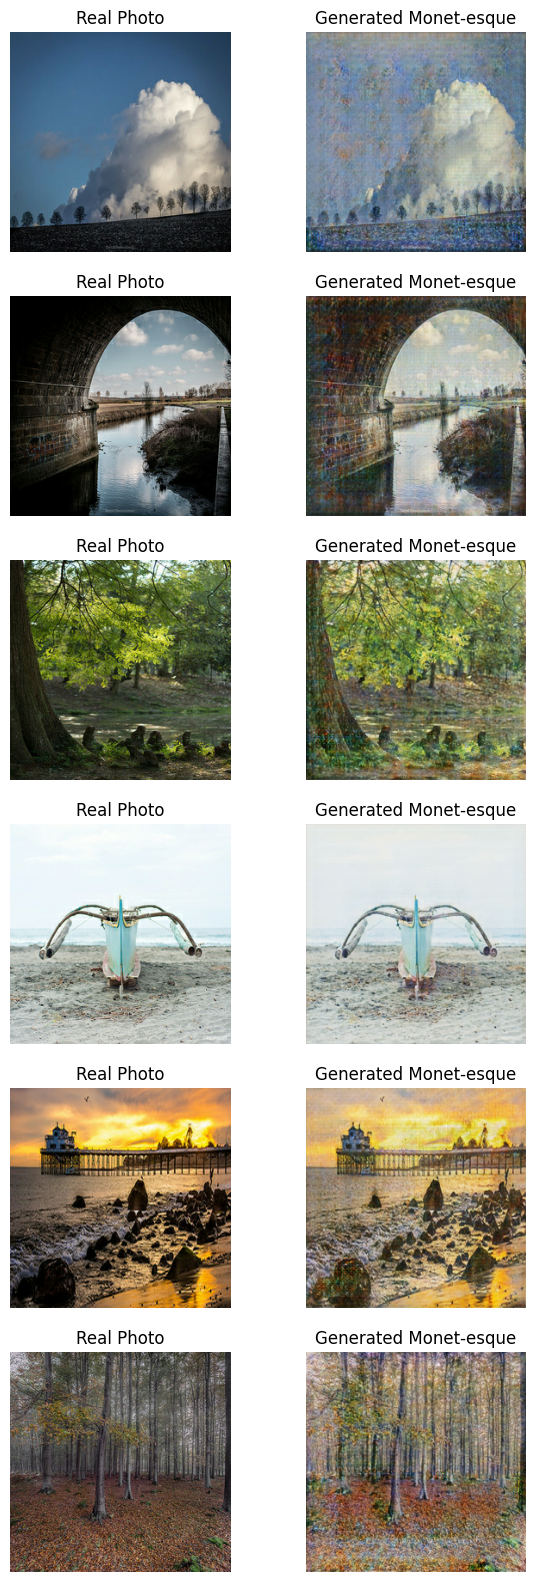

In [56]:
fig,ax= plt.subplots(6,2, figsize=(7,20))
for i,img in enumerate(photo_data.take(6)):
    pred= monet_generator(img, training= False)[0].numpy()   # training= False to make sure not to update model's weights
    pred= (pred*127.5 + 127.5).astype(np.uint8)              # making pixel range to [0,255]
    img= (img[0]*127.5 + 127.5).numpy().astype(np.uint8)
    
    ax[i,0].imshow(img)
    ax[i,1].imshow(pred)
    ax[i,0].set_title('Real Photo')
    ax[i,1].set_title('Generated Monet-esque')
    ax[i,0].axis('off')
    ax[i,1].axis('off')

### Training Performance

In [ ]:
# Plotting the losses with correct x-axis values
plt.figure(figsize=(10, 8))
epochs = range(1, len(callback.losses['disc_photo_loss']) + 1)
plt.plot(epochs, callback.losses['disc_photo_loss'], label='disc_photo_loss')
plt.plot(epochs, callback.losses['disc_monet_loss'], label='disc_monet_loss')
plt.plot(epochs, callback.losses['gen_photo_loss'], label='gen_photo_loss')
plt.plot(epochs, callback.losses['gen_monet_loss'], label='gen_monet_loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

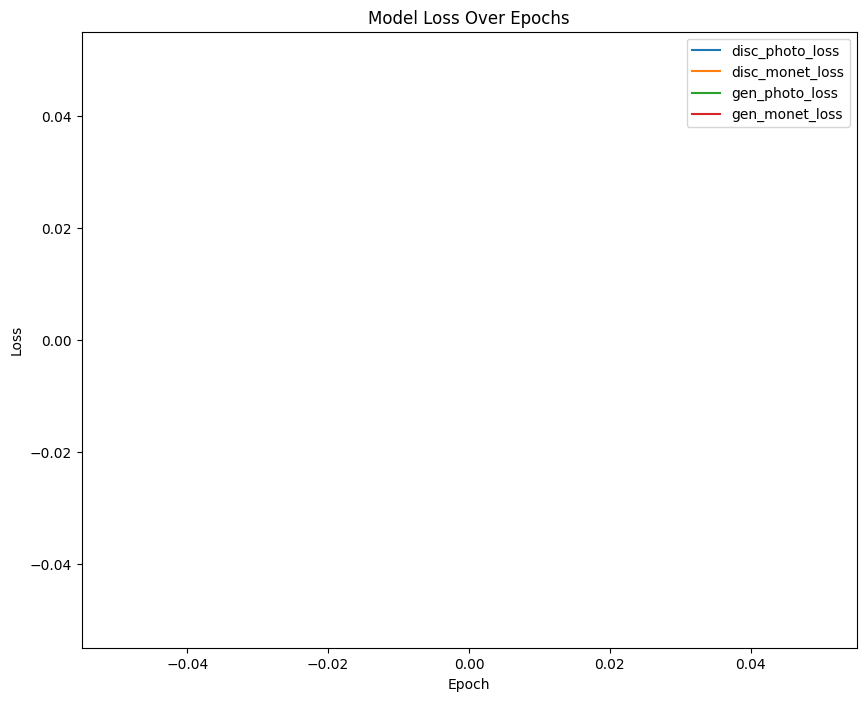

The GANs model has been trained for 50 epochs. The loss values are decreasing with each epoch. The generate could generate the monet-esque images with some noise effectively. It means our model learned successfully. However, the graph could not show the exact trend of the loss values due to failure in saving loss history. This is the improvement for this project for making it perfect.